In [16]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

### Data Acquisition

#### Create DataFrame

* Create dataframe with image_path, time(seconds) and speed

* In the video given, we have ~344 (5min 44s) seconds of video. 
* Our ground truth labels correspond to a video that is 12m 12s (~732seconds). 
* We only have a portion of that video. 
* It appears that our framerate <strong>~ 13 fps </strong>. (4459 frames * (1 second / 13frames) = 344 seconds)

In [2]:
df = pd.read_csv('./data/driving.csv')
df.head(10)
len(df)

4459

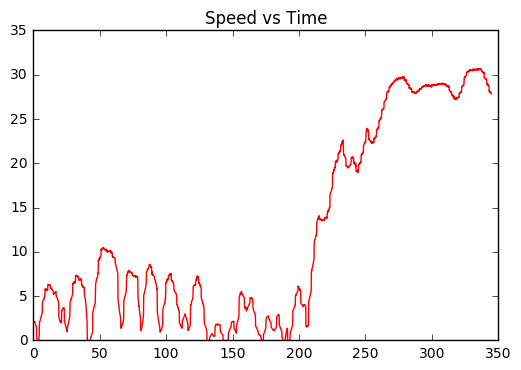

In [3]:
times = np.asarray(df['time'], dtype = np.float32)
speeds = np.asarray(df['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.show()

In [4]:
df.tail(5)

,image_path,time,speed
4454,./data/IMG/344.3211498260498.jpg,344.321150,27.928958
4455,./data/IMG/344.37305998802185.jpg,344.373060,27.938640
4456,./data/IMG/344.5106108188629.jpg,344.510611,27.932405
4457,./data/IMG/344.5854048728943.jpg,344.585405,27.927574
4458,./data/IMG/344.63681387901306.jpg,344.636814,27.847842


## Train Test Split

In [17]:
train_data, valid_data = train_test_split(df, test_size = 0.2)

## Preprocess

In [5]:
def change_brightness(image):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    bright_factor = 0.2 + np.random.uniform()
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

#### Perspective Transform

In [6]:
def apply_perspective_transform(image):
    pass

In [7]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (256, 256, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             2) Perspective transform
             3) resize to (256, 256, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    image_cropped = image[100:, :-90] # -> (380, 550, 3)
    
    # TODO: Write perspective transform 
#     perspective = apply_perspective_transform(image_cropped)
    
    image = cv2.resize(image_cropped, (256, 256), interpolation = cv2.INTER_AREA)
    
    return image
    
    
    
    
    

In [8]:
def preprocess_image_valid_from_path(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img

In [9]:
def preprocess_image_from_path(image_path):
    """
    input: image
    Can do things here that are only performed on training data
    output: processed image
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # change brightness here
#     img = change_brightness(img)

    img = preprocess_image(img)
    return img

### Generators

In [22]:
def generate_training_data(data):
    while True:
        idx = np.random.randint(len(data) - 1)
        row1 = data.iloc[[idx]].reset_index()
        row2 = data.iloc[[idx + 1]].reset_index()
        
        x1 = preprocess_image_from_path(row1['image_path'].values[0])
        x2 = preprocess_image_from_path(row2['image_path'].values[0])
        
        s1 = row1['speed'].values[0]
        s2 = row2['speed'].values[0]
        
        ds = s2 - s1
        
        yield x1, x2

In [23]:
def generate_validation_data(data):
    while True:
        for idx in range(len(data) - 1):
            row1 = data.iloc[[idx]].reset_index()
            row2 = data.iloc[[idx + 1]].reset_index()
            
            x1 = preprocess_image_valid_from_path(row1['image_path'].values[0])
            x2 = preprocess_image_valid_from_path(row2['image_path'].values[0])
            
            s1 = row1['speed'].values[0]
            s2 = row2['speed'].values[0]
        
            # calculate speed difference
            ds = s2 - s1
            
            yield x1, x2

### Test out preprocessing

In [46]:
rand_int = np.random.randint(0, 4459)
rand_int

4071

In [47]:
row = df.iloc[[rand_int]].reset_index()
# print('row: ', row)
print('speed: ', row['speed'].values[0])


speed:  28.6642780737


In [48]:
path = df.loc[rand_int]['image_path']
print(path)

./data/IMG/311.45286083221436.jpg


rand_img shape:  (480, 640, 3)


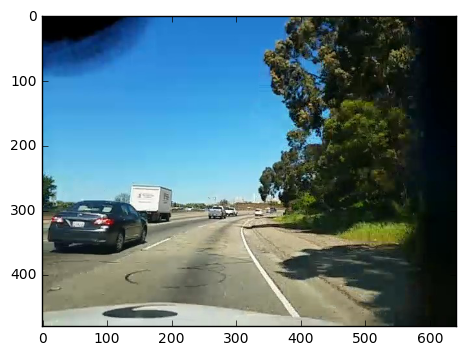

In [49]:
rand_img = mpimg.imread(path)
print('rand_img shape: ', rand_img.shape)
plt.imshow(rand_img)

In [50]:
image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)

(380, 550, 3)


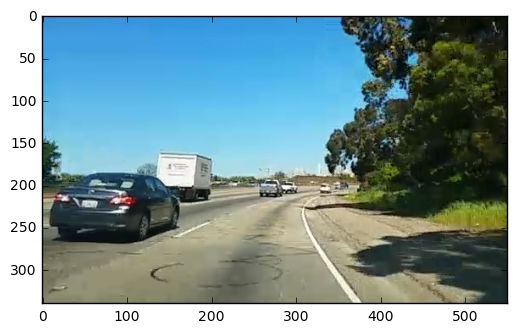

In [51]:
image_cropped = rand_img[100:440, :-90]
print(rand_img2.shape)
plt.imshow(image_cropped)

In [52]:
image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)


### Network Architecture (DeepVO AlexNetLike)

In [12]:
from keras.layers import Input, Dense, Activation, Flatten, merge
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam


tf.python.control_flow_ops = tf

# image_1 = Input(shape = (3, 256, 256), name='image1')
# image_2 = Input(shape = (3, 256, 256), name='image2')

# N_img_height = 256
# N_img_width = 256
# N_img_channels = 3

# inputShape = (N_img_height, N_img_width, N_img_channels)
def DeepVo():
    # TODO: Maybe add zeroPadding2D(1, 1) after each layer
    # TODO: Maybe take out input_shape = inputShape from first conv layer
    
    # Loading inputs: 
    image_1 = Input(shape = (256, 256, 3), name='image1')
    image_2 = Input(shape = (256, 256, 3), name='image2')
    
    ######## LAYER 1 ####################
    # Convolution Layer 1: Channel 1
    x1 = Convolution2D(48, 11, 11, subsample=(4, 4), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu',
#                       input_shape = inputShape,  # may not be necessary
                      name = 'conv_1_x')(image_1)
    
    # Convolution Layer 1: Channel 2
    y1 = Convolution2D(48, 11, 11, subsample=(4, 4), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu',
#                       input_shape = inputShape,  # may not be necessary
                      name = 'conv_1_y')(image_2)
    
    # Max Pooling Layer 1: Channel 1
    x1 = MaxPooling2D((3, 3), strides = (2, 2))(x1)
    
    # Max Pooling Layer 1: Channel 2
    y1 = MaxPooling2D((3, 3), strides = (2, 2))(y1)
    ######## END OF LAYER 1 ####################

    ######## LAYER 2####################
    # Convolution Layer 2: Channel 1
    x1 = Convolution2D(128, 5, 5, subsample = (1, 1), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu', 
                      name = 'conv_2_x')(x1)
    
    # Convolution Layer 2: Channel 2
    y1 = Convolution2D(128, 5, 5, subsample = (1, 1), 
                      init = 'he_normal', 
                      border_mode = 'valid', 
                      activation = 'relu', 
                      name = 'conv_2_y')(y1)
    
    # Max Pooling Layer 1: Channel 1
    x1 = MaxPooling2D((3, 3), strides = (2, 2))(x1)
    
    # Max Pooling Layer 1: Channel 2
    y1 = MaxPooling2D((3, 3), strides = (2, 2))(y1)
    
    ####### LAYER 3 ###################
    # Convolution Layer 3: Channel 1
    x1 = Convolution2D(192, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_3_x')(x1)

    # Convolution Layer 3: Channel 2
    y1 = Convolution2D(192, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_3_y')(y1)
    
    ####### LAYER 4 ###################
    # Convolution Layer 4: Channel 1
    x1 = Convolution2D(192, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_4_x')(x1)

    # Convolution Layer 4: Channel 2
    y1 = Convolution2D(192, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_4_y')(y1)
    
    ####### LAYER 5 ###################
    # Convolution Layer 5: Channel 1
    x1 = Convolution2D(192, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_5_x')(x1)

    # Convolution Layer 5: Channel 2
    y1 = Convolution2D(192, 3, 3, subsample = (1, 1), 
                  init = 'he_normal', 
                  border_mode = 'valid', 
                  activation = 'relu', 
                  name = 'conv_5_y')(y1)
    
    ####### Flatten ###########
    x2 = Flatten(name='flatten_x1')(x1)
    y2 = Flatten(name='flatten_y1')(y1)
    
    # TODO: Maybe add a relu after these layers
    ###### Fully Connected 1 using Xaviers algorithm (glorot normal) ########
    x3 = Dense(2048, activation = 'relu', init = 'glorot_normal', name = 'fc1_x2')(x2)
    y3 = Dense(2048, activation = 'relu', init = 'glorot_normal', name = 'fc1_y2')(y2)
    
    ###### Fully Connected 2 ########
    x3 = Dense(2048, activation = 'relu', init = 'glorot_normal', name = 'fc2_x2')(x2)
    y3 = Dense(2048, activation = 'relu', init = 'glorot_normal', name = 'fc2_y2')(y2)
    
    ##### Merge ####### 
    # TODO: Try concatenation instead of merging
    print('x3 shape: ', x3.get_shape())
    m3 = merge([x3, y3], mode='concat', concat_axis = 1, name = 'merge_x3y3')
    
    print('m3 shape: ', m3.get_shape())
    #### Flatten #####
#     flat3 = Flatten(name = 'flatten_merge')(m3)
    
    #### Fully connected 3 ######
    fc3 = Dense(4096, activation = 'relu', init = 'glorot_normal', name = 'fc3')(m3)
    
    ### Fully connected 4 ######
    fc4 = Dense(1024, activation = 'relu', init = 'glorot_normal', name = 'fc4')(fc3)
    
    ### Fully connected 5 ######
    prediction = Dense(1, name = 'output')(fc4)
    
    model = Model(input = [image_1, image_2], output = [prediction, prediction])
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')
    
    return model
    
    

Using TensorFlow backend.


### Manually create testing data

#### Create the model

In [13]:
model = DeepVo()



x3 shape:  (?, 2048)
m3 shape:  (?, 4096)


In [19]:
BATCH = 2
train_size = len(train_data.index)
val_size = len(valid_data.index)
print('train size: ', train_size)
print('val_size: ', val_size)

train size:  3567
val_size:  892


In [20]:
valid_generator = generate_validation_data(valid_data)
BATCH = 2

In [21]:

for i in range(3):
    train_generator = generate_training_data(train_data)
    history = model.fit_generator(
            [train_generator, 
            samples_per_epoch = train_size, # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    history = model.fit_generator(train_generator, samples_per_epoch = 1, nb_epoch = 1)

Epoch 1/6


Exception: The model expects 2 input arrays, but only received one array. Found: array with shape (256, 256, 3)

In [ ]:
modelx = DeepVo()
print('model created!')
